真神降临

transformer其实和seq2seq是类似的架构，通过encoder-decoder来构造出来的
* transformer的本质是，通过encoder-decoder架构来利用纯注意力机制处理序列对
* 和前面seq2seq或者是注意力机制的seq2seq不同，transformer使用了纯注意力机制，放弃了seq2seq中的两个RNN结构（分别是encoder和decoder）
* transformer和别的网络一样，构造了很多transformer块，其实和ResNet里面的block是性质一样的东西

这里我们需要引入一个新的注意力机制，叫多头注意力，multihead
* 多头注意力的结构可以参考李沐老师的视频，个人理解为本质是构建了多个attention，这里每个attention对应的都是相同的key、query、value三要素
* 还记得attention我们是有可学习的参数的，多个attention其实也就是参数不同，我们这样可以抽取不同的序列信息（长的短的）
* 最后我们把这些不同attention的输出concat起来，然后再扔进一个FC层里面，最终输出一个总的结果
* 其实从数学公式上能够比较好的理解这个过程（看维度的变化）


另一方面，还有一个叫掩码多头注意力，mask multihead
* 掩码多头注意力其实是为了解决，attention机制没有位置信息这一问题的
* 还记得最原始的attention函数吗（以这个为例子），最原始的attention函数其实你就是一个算距离的东西，四舍五入不是个KNN吗
* 所以attention这玩意本质上是不能记住位置信息的
* 前面seq2seq我们用attention，但是不用担心这个是因为，seq2seq本质上还是RNN，RNN这玩意自带位置信息
* 那我们前面也讲了，对于attention我们可以用Positions来给输入标上位置信息
* 但是我们做decoder的时候，不能这样做，因为decoder你不能说用后面的信息来预测前面的信息，这显然不合理（encoder无所谓，反正你输入的都是整个序列）
* 掩码的解决办法其实很巧妙，前面我们也讲过，用掩码的办法来处理valid len
* 那掩码多头实际操作就是，你的decoder输出第Xi个元素的时候，我就假设你valid len就是i，后面的我全部当成填充
* 这样算注意力就不会算后面的，从而校正位置信息的影响

transformer里面还有一个新的层，叫基于位置的前馈网络层FNN
* FNN实质上是两个FC层，中间照例加了个relu进去
* FNN的作用就是，把输入X的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）被一个两层的感知机转换成形状为（批量大小，时间步数，ffn_num_outputs）的输出张量
* 其实看下面FNN的实现代码会很清晰，这玩意真的就是一个MLP
* 不过还是有点疑惑，为什么要加一个这个FNN呢？因为好像也没做啥

最后一个新的层，叫Add&norm层
* 这add层，实际上就是ResNet里面的那玩意，就是一个残差，为了让我们的网络可以变得更深，这样可以一直加很多很多个transformer block
* norm其实也是老东西，也就是前面数值稳定性那里讲过的归一化
    * 但是前面我们讲的batch norm，并不适用于我们这里的NLP序列应用
    * 因为batch norm是对每个特征（或者说通道）里面的元素进行归一化，但NLP里面你的序列长度是会发生变化的，所以这样还是导致了不稳定
    * 在transformer里面，我们使用layer norm，也就是对每个样本中的元素进行归一化
    * 这玩意比batch norm更加稳定一点
    * 不过norm的方法有很多很多种，说不定也有更好的呢~

transformer整个架构中的信息传递是这样进行的（图示可以看李沐老师的视频）：
* 其实整个信息传递还是简单的
* 首先transformer中encoder-decoder中block数量是相同的（为了简单和对称）
* encoder每个block出来的输出，这里是self attention出来的输出，会作为对应decoder中block中间那个attention的key-value（中间那个attention是正常attention）
* 这里唯一要注意的就是，encoder一个block里面只有一个self attention，而decoder是前面一个self再跟着一个正常attention
* 其实你会发现，这里的思想和seq2seq里面用attention是很相似的

下面我们来看看transformer的实现，首先是multihead的实现机制

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#@save
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        # 这里是为了简单，直接用了点乘的那种注意力
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # 这里的目的就是多个head不想用for loop......
        # 不过这里实现挺巧妙的，是一种很cs的代码
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

为了能够使多个头并行计算， 上面的MultiHeadAttention类将使用下面定义的两个转置函数。 具体来说，transpose_output函数反转了transpose_qkv函数的操作。

In [3]:
#@save
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [4]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [5]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

In [6]:
# 这就是我们前面提到的FFN，完完全全的MLP
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [7]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.7047, -0.4506,  0.0484,  0.1738,  0.1223, -0.2161, -0.0260,  0.1680],
        [ 0.7047, -0.4506,  0.0484,  0.1738,  0.1223, -0.2161, -0.0260,  0.1680],
        [ 0.7047, -0.4506,  0.0484,  0.1738,  0.1223, -0.2161, -0.0260,  0.1680]],
       grad_fn=<SelectBackward0>)

In [8]:
# 接下来我们对比一下batch layer norm
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [9]:
#@save
# 这里就是加了个residual
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)
    
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [10]:
#@save
# 这里我们就是来实现一个，encoder的transformer block
# 其实看一下会发现也没啥特殊的，就是把上面的那些模块组合一下
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [11]:
# 进去出来形状并不会发生改变
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [12]:
#@save
# 接着来实现整个encoder
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        # 这里一个重要参数就是要多少个transformer block
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        # 这里用了math.sqrt(self.num_hiddens)来缩放，其实就是为了让X embedding出来之后，和我们加上的P数值差异不要太大
        # 众所周知，机器学习里面样本数值差异太大是不太好的
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        # 这里本质上其实是一个sequential......写个for loop只是为了把attention_weights存起来，方便可视化
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [13]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape
# 同样形状没变

torch.Size([2, 100, 24])

In [14]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        # 这里很重要的一点是，我们要把i记住，还记得吗，encoder-decoder的block是存在对应关系的
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [15]:
# 这里其实就没啥区别了
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.031, 5584.2 tokens/sec on cuda:0


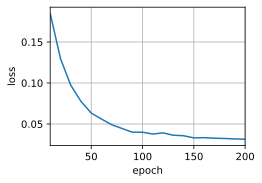

In [16]:
# 开始炼丹！
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
# 这里一样 要改一下
net = d2l.EncoderDecoder_simple(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)
# 可以发现这玩意训练速度挺快的，一点都不慢，因为并行度比RNN好特别多

In [17]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')
    # 这训练效果真牛逼

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [18]:
# 可以看一下自注意力机制权重的样子
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

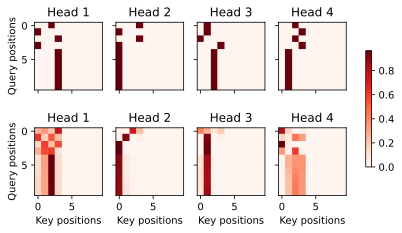

In [19]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

# 这其实可以体现出multihead的作用
# 每个head query去看的东西都不太一样

后面还有一些可视化，但是感觉没啥特别重要的，就先暂时忽略了，可以详见课件

* 可以发现，transformer虽然名字看起来很fancy，但是他的这个架构还是很好理解的，并且这个架构具有很良好的迁移性
* 所以现在不仅仅在序列问题上，在其他很多问题上，transformer架构也被广泛的应用了（像什么bert、gpt都是这一套）
* 课后提问有人提到，多头注意力的时候，多个attention是concat还是做加权平均呢？其实感觉加权平均也是可行的，不过李沐老师说concat能够保留更多的信息